![McLaren Maze Race Banner](media/banner.png)

# Welcome to Rookie Driver - level 3 of the McLaren Maze Race!

In this level we look at a major update to our AI algorithm, switching from Q Learning to a model-based method. DRS is also available at certain points around the mazes, which provides a way for the driver to go even faster - if the AI decides it is worth the extra turn to activate it.

## Model-based Reinforcement Learning

Let's first look at updating our AI's brain. Up until now we have been using Q Learning, which is a form of model-free reinforcement learning. It is called that because it does not build an explicit model of the environment which can predict what will happen if the AI takes a particular action. Model-free methods generally require fewer assumptions and less knowledge about the environment to do well: the only prior knowledge that we gave the algorithm so far is the choice of state vector and only considering turns at the end of the straight. If you need to train an AI agent to solve a task and you have very little information about it then a model-free method will often get the job done. However, this flexibility comes at a cost: model-free methods usually require a lot more data to learn from than model-based methods, which are able to extra more learning from the same information (although this does depend on the specifics of the algorithm and environment).

In our maze race, data efficiency is key - our driver only has 24 races in the season and needs to learn as fast as possible! For this reason we will look at a model-based method. The idea is to learn two things about our car:
- the fastest, safe end-of-straight speed
- the effect of each action on car speed

If we know both of these then we can choose the optimal set of actions to drive the car as fast as possible down the straight and still make the corner at the end. The critical choice in model-based learning is the choice of our model. If the model we choose isn't able to capture the true shape of car's dynamics, then it will make very bad predictions which will lead the AI astray. This is why it is important to know something about the environment when using a model-based method. If you have access to data from the environment, it is a good idea to study it before choosing a model class. In our case we can plot the dynamics functions for a sample car:

In [1]:
%matplotlib ipympl
from imports import * 

set_seed(0)
car = Car.get_car_for_level(Level.Rookie)
plot_car_dynamics(car)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

We can see that the functions mapping "speed in" to "speed out" for three of the four actions are nonlinear, that is, they are not straight lines. If we chose a linear model our AI would probably do much worse than the Q Learning approach we have been taking so far. We could try and exactly replicate the form of the functions shown above (which look to be piecewise linear) however this would also be dangerous as these dynamics are randomly generated each time and will be different in the online challenge. We therefore need a general nonlinear model that can adapt itself to the shape as data arrives.

There are two aspects of the maze race that make this modelling task much easier: we know what the car speed is exactly (without any noise) and we know the speed at next turn only depends on our current speed and the action that we take (advance warning - at higher levels this is going to change!). This means we can use a simple linear interpolation algorithm for each action. When we want to predict the next speed for an action, we find the closest two speeds we have seen previously (for the same action), draw a straight line between them and use that to estimate our output speed. With just two data points this would be a simple linear model, however, as we gather more and more data the complexity of the shape will adapt to the data that is observed (this is known as a *nonparametric* regression model). Here is an example of fitting the Heavy Brake curve as we get more and more data:

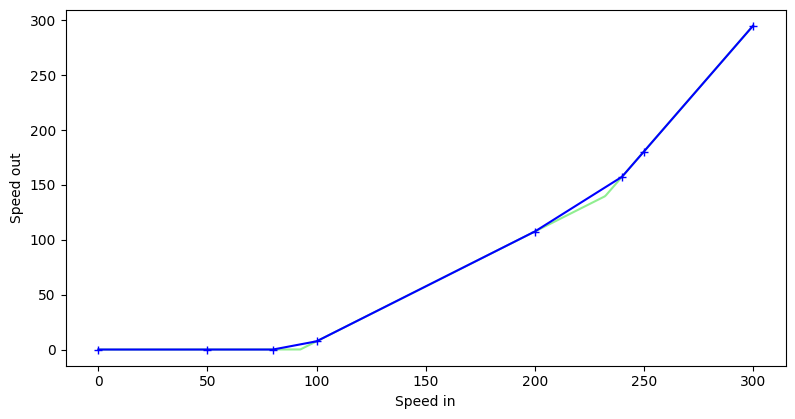

In [2]:
from scipy.interpolate import interp1d
from IPython.display import display, clear_output
speed_in = np.linspace(0, 300, 500)
true_speed_out = np.array([car.dynamics_model.heavy_brake(s) for s in speed_in])
fig = plt.figure(figsize=(8,4))
clear_output()
hdisplay = display(fig, display_id=True)
ax = fig.add_axes([0.09, 0.11, 0.9, 0.89])
ax.plot(speed_in, true_speed_out, c='lightgreen')
data_in, data_out = [], []
data_plot = ax.plot(data_in, data_out, 'b+')[0]
interp_plot = ax.plot([], [], 'b')[0]
ax.set_xlabel('Speed in')
ax.set_ylabel('Speed out')
for x in [100, 200, 250, 300, 0, 50, 240, 80]:
    data_in.append(x)
    data_out.append(car.dynamics_model.heavy_brake(data_in[-1]))
    data_plot.set_data((data_in, data_out))
    if len(data_in) > 1:
        f = interp1d(data_in, data_out, fill_value='extrapolate')
        interp_plot.set_data((speed_in, f(speed_in)))
    hdisplay.update(fig)
    plt.pause(0.5)
plt.close()

We can estimate the maximum, safe, end-of-straight speed in the same way we estimate the safety car speed: start with an initial guess and then if we successfully make it around the corner we can increase our guess and if we crash we decrease our guess.

Now we have the building blocks in place for our models we need to decide how to use them to choose our actions. We will start at the end of the straight where we already have a target speed: our estimate of the fastest, safe, end-of-straight speed. We can now work backwards up the straight, using our models to work out how fast we can go at the previous step and still make it below the target speed at the current step. If the models were invertable, then we could easily swap them from mapping speed in to speed out to models that went from speed out to speed in. However, the saturation at 0 and the car's top speed make this tricky (there might be other noninvertible regions at higher levels as well). Therefore, we will instead use a forward simulation approach: for each action we will feed in an array of different input speeds and find the one that gets closest to the target speed. We will then take the fastest input speed over all of the actions and set this to be the target speed for the previous step - we know that if we are travelling at this speed then (if our model is correct) there is an action we can take that will bring us to the target speed. This process in outlined in the figure below.


<img src="media/estimating_target_speeds_from_model.PNG" alt="Estimating target speeds from model" width="800"/>

Once we have a target speed for each position on the straight we can choose the action we want to take at our current position by finding the action that gets us closest (but below) the target speed. To do this we just need to call our dynamics models with our current speed to get their predicted output speed for each action. Here is the code implementation of this final step:

    def _choose_move_from_models(self, speed: float, target_speed: float, drs_active: bool, safety_car_active: bool):
        # Test each action to see which will get us closest to our target speed
        actions = CarAction.get_sl_actions()
        next_speeds = np.array([self.estimate_next_speed(action, speed, drs_active) for action in actions])
        errors = next_speeds - target_speed    # difference between predicted next speed and target, +ve => above target
        
        # The target speed is the maximum safe speed so we want to be under the target if possible. This means we don't
        # necessarily want the action with the smallest error
        if np.any(errors <= 0):            # under or equal to the target speed
            errors[errors > 0] = np.inf    # at least one action gets us under the speed so ignore others even if close
        
        # Now we can choose the action with the smallest error score. At the start there will be multiple actions with
        # with the same score, so we will choose randomly from these
        min_error = np.min(errors ** 2)
        available_actions = [action for action, error in zip(actions, errors)
                             if np.abs(error ** 2 - min_error) < 1e-3]

        return self._choose_randomly(available_actions)
        
 Now let's test out our new driver!

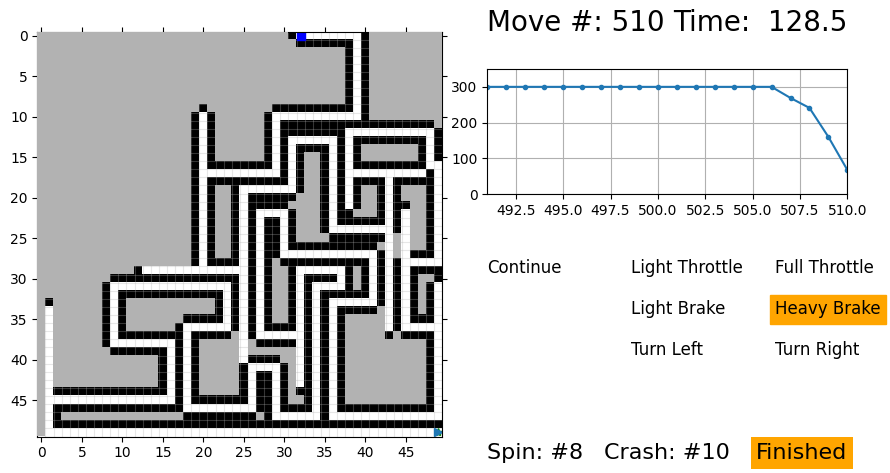

	Crashed! We targeted  350 speed and were going  275
New target speeds: mid-straight->[350. 350. 350. 350. 350. 265.]<-end
	Crashed! We targeted  265 speed and were going  263
New target speeds: mid-straight->[350. 350. 350. 350. 350. 253.]<-end
	Crashed! We targeted  253 speed and were going  163
New target speeds: mid-straight->[350. 350. 350. 350. 350. 153.]<-end
	Crashed! We targeted  153 speed and were going  151
New target speeds: mid-straight->[350. 350. 350. 327. 234. 141.]<-end
	Crashed! We targeted  141 speed and were going  123
New target speeds: mid-straight->[350. 350. 350. 299. 206. 113.]<-end
	Crashed! We targeted  113 speed and were going  262
New target speeds: mid-straight->[350. 319. 286. 256. 206. 113.]<-end
New target speeds: mid-straight->[350. 331. 297. 266. 218. 126.]<-end
	Crashed! We targeted  126 speed and were going  262
	Crashed! We targeted  126 speed and were going  121
New target speeds: mid-straight->[350. 324. 290. 260. 203. 111.]<-end
New target speed

In [3]:
from drivers.rookiedriver import RookieDriver

driver_name = 'Ricorris'
driver = RookieDriver(driver_name)
set_seed(1)
# Turn off DRS and safety car for the moment to focus on new driver performance
race(driver=driver, level=Level.Rookie, track_index=1, plot=True, use_safety_car=False, use_drs=False);
plt.close()

Well it crashed quite a lot but this is the first maze race that the driver has seen. It also hit a lot higher speeds than we have seen before - reaching "Vmax" (or maximum speed) several times. Also many of the crashes happen at dead ends, which should be eliminated as the driver sees more tracks.

We can see how the driver adjusts the targeted speeds at the end of a straight depending on what happened. The target speeds can change for two reasons: either because the driver crashed and has lowered the end-of-straight speed or because the dynamics models have updated and the AI now has a better estimate of how the speeds will change each turn as actions are applied.

There are two aspects of the training, which we introduced in the previous levels, that we haven't talked about so far in this level. The first is the random action probability. We still need a way of encouraging the driver to explore new actions rather than purely exploiting the existing learning and so we make use of the same random action probability as before. There is an opportunity here though for you to improve the AI if you want to: we have a much better idea of where we need to explore in this algorithm as we can check the data we have already collected and see if the action we are about to take is likely to teach us something new or not. For example, if we see that we already have a data point in the dynamics model at a very similar speed for an action then we won't learn much new by taking that action; it might be better to take an action that doesn't have any data points nearby and hence learn a lot. If all actions have nearby data then we know that exploitation is the best approach.

The second feature that we haven't spoken about is the learning rate. We don't have the speed quantisation in this algorithm that we had previously, however, the maximum, safe, end-of-straight speed that we learn is strongly affected by dead ends. At the start of training the driver is likely to come across several dead ends as the AI hasn't yet learnt the correct turns to make. This means that the driver learns a much more conservative end-of-straight speed than it needs if a turn was always available as it has to be able to brake to a halt at a dead end. As learning progresses the driver should eliminate dead ends and so it is safe to raise the end-of-straight speed. One way of doing this is to use a learning rate parameter either directly on the end-of-straight speed or perhaps by modelling dead end speeds and cornering speeds separately and blending between them. We leave this up to you!

### DRS
It is time now to talk about the drag reduction system - DRS. Just like in F1, DRS is available at various points around the track (indicated by cyan triangles in the track plots). When the driver reaches one of these points the `drs_available` flag will be set in `track_state` and the driver can choose to use the `OpenDRS` action (attempting to use this action when DRS is not available will result in a `Continue` action being applied instead). If the driver chooses to open the DRS then the car will proceed for one turn at its current speed and then open the DRS. With the DRS open, the car's top speed is increased and so the driver can reach speeds not otherwise possible. Again, like in F1, the DRS will automatically close as soon as the brakes are applied, but be aware that braking from the higher speed is more risky! 

It won't always be quicker to open the DRS when it is available. This is because opening the DRS fixes your speed for one turn, which is obviously bad if it is at the end of the straight and you need to be braking for the corner, but might also be bad earlier in the straight as it means that you miss a turn's acceleration. The optimal choice depends on your current speed and how much of the straight is left. The AI needs to learn to make this trade-off.

In a model-based algorithm, we can tackle this problem by simulating the rest of the straight using our learnt dynamics models, both with, and without, DRS open. We can then compare the two simulated outcomes and apply the action that we believe will lead to the faster time. This is very similar to the approach a human would take to choosing the best way to get home from school/work!

Let's turn on DRS and watch our new AI at work.

In [9]:
season = Season(Level.Rookie)
set_seed(0)
print('Running races...')
# Get some learning under our driver's belt
driver, *_ = season.race(driver=driver, track_indices=range(14), plot=False);     
driver, *_ = season.race(driver=driver, track_indices=[14], plot=True, use_safety_car=False);
plt.close()
print('done')

Running races...
Opening DRS
Opening DRS
New target speeds: mid-straight->[348. 312. 280. 250. 181.  89.]<-end
Opening DRS
Opening DRS
New target speeds: mid-straight->[349. 313. 281. 251. 182.  90.]<-end
Opening DRS
New target speeds: mid-straight->[349. 313. 281. 252. 184.  92.]<-end
done


One thing we need to be careful of is ensuring the AI explores DRS enough. There are only a few chances in a race to open DRS and many of these might be in places where it is slower to active it. This means that we might struggle to get data to populate the dynamics models with DRS open. To try and counter this we add in a heuristic that will open DRS if any of the actions have fewer than 3 data points recorded under DRS. This is a very basic step to encourage exploration - you might like to come up with something better!

An alternative is to model DRS as a modifier on top of the the non-DRS data, which would allow us to use a single pool of data rather than having to learn two separate models for each action. The downside is that this is a more restrictive model and, if it doesn't match reality, could lead to much worse performance. We also leave this up to you to explore.

### Safety Car

We have kept the same mechanism for dealing with the safety car that was introduced in level 2: we keep a running estimate of the current safety car speed, decreasing it each time we get a penalty. This estimate can be naturally incorporated into the framework discussed above by capping the target speeds at each point on the straight to our current estimate of the safety car speed. Unlike our previous approach our new AI algorithm won't keep accelerating back above the safety car speed because the target speed is also taken into account when accelerating from a slower speed, not just when we are above it. We can see this behaviour in the safety car sim.

Running safety car sim...
Safety car deployed for 50 turns at 100 speed
	Decreasing estimate of safety car speed to  72.0
	Increasing estimate of safety car speed to  121.8
	Decreasing estimate of safety car speed to  58.4
	Increasing estimate of safety car speed to  103.8


<IPython.core.display.Javascript object>


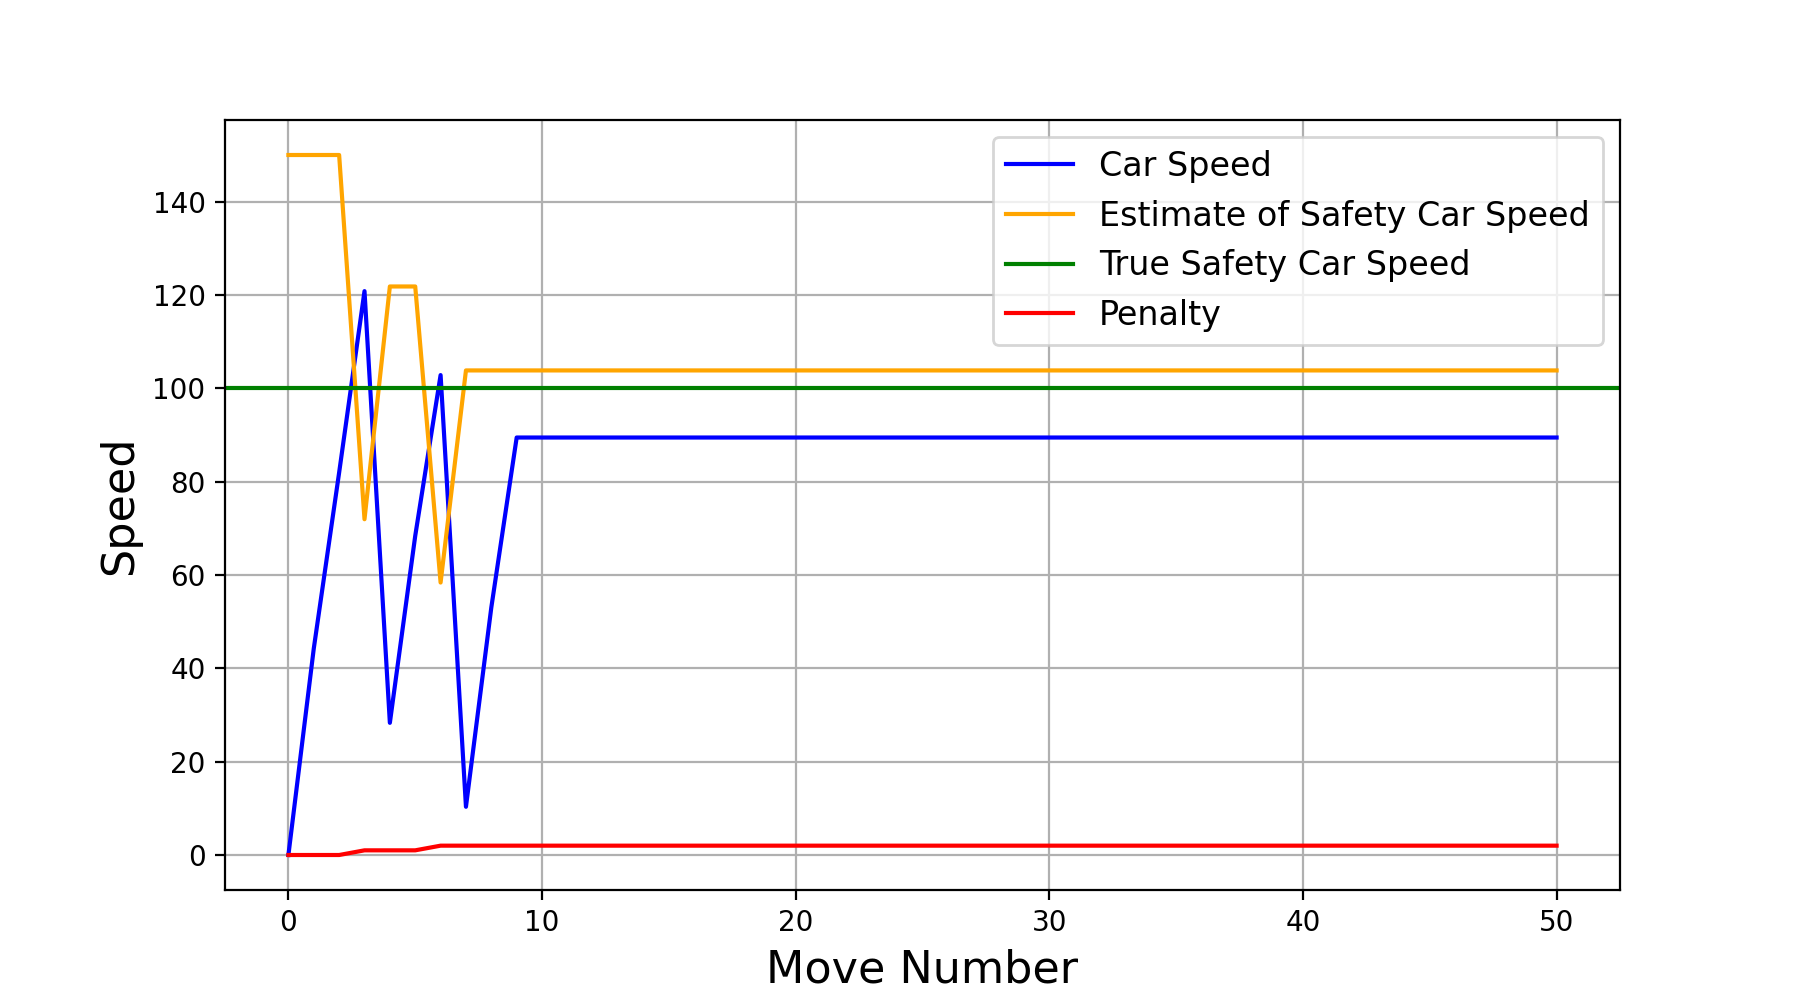

Complete


In [10]:
# Run the safety car sim
set_seed(0)
driver = RookieDriver(driver_name)   # always best to reset driver for sim
car_speed, safety_car_estimate, safety_car_true, safety_car_penalty = safety_car_sim(driver, level=Level.Rookie)

We can see how, once the safety car speed has stabilised, the driver stays below the estimated speed and doesn't keep accelerating above it. This is much better than we saw before.

If you want to investigate some advanced behaviour then you might want to look at the safety car speeds and durations as you might find they are not totally random and there might be some predictions you can learn to make that will allow your driver to save some more time! Remember that in the online challenge the general form of any relationships you discover will stay the same but the exact parameters will change so you need to develop a learning algorithm rather than hardcoding in some values.

# End of level and the Online Challenge
This is the end of the Rookie Driver level. We now have a driver that is able to efficiently learn from just a small amount of data to control the car, navigate the mazes, and deal with the safety car and DRS. There are a number of improvments that were suggested above that can be made to our algorithm, which you might like to try. If you think you have improved the driver then why not test it out by entering it into the Rookie Driver challenge on the [McLaren Maze Race website](www.mclaren.com/mazerace)?

In the next level we will introduce tyres, pit stops, and rain. If you master that, your AI will be a pro driver!

### We hope to see you in Pro Driver, level 4 of the McLaren Maze Race!

# Playground
If you want to play around with the driver AI here, then it might be helpful to use this class.

In [4]:
class MyRookieDriver(RookieDriver):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def make_a_move(self, car_state: CarState, track_state: TrackState):
        return super().make_a_move(car_state, track_state)
        
    def estimate_next_speed(self, action: Action, speed, drs_active: bool):
        return super().estimate_next_speed(action, speed, drs_active)
    
    def _choose_move_from_models(self, speed: float, target_speed: float, drs_active: bool):
        return super()._choose_move_from_models(speed, target_speed, drs_active)
    
    def update_with_action_results(self, previous_car_state: CarState, previous_track_state: TrackState,
                                   action: Action, new_car_state: CarState, new_track_state: TrackState,
                                   result: ActionResult):
        super().update_with_action_results(previous_car_state, previous_track_state, 
                                           action, new_car_state, new_track_state, result)
    
    def _update_safety_car(self, new_car_state: CarState, result: ActionResult):
        super()._update_safety_car(new_car_state, result)
        
    def update_target_speeds(self):
        super().update_target_speeds()

my_driver = MyRookieDriver(driver_name)

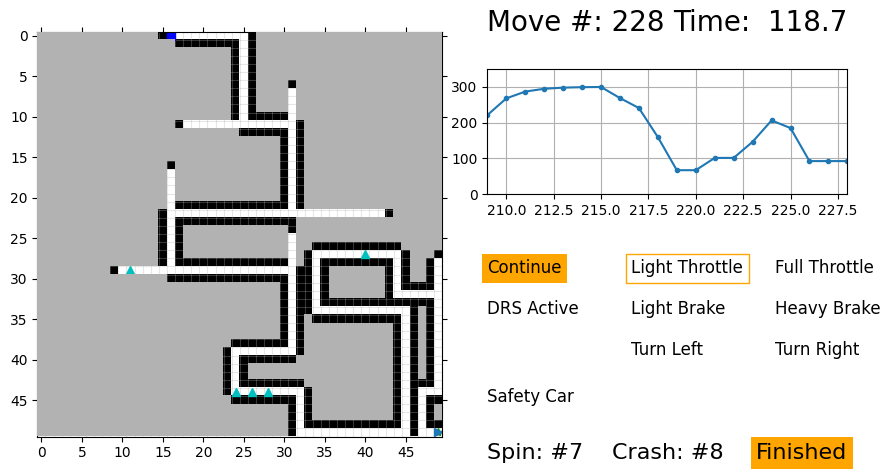

Safety car deployed for 12 turns at 100 speed
	Car speed of  106.9 exceeds safety car, penalty is now 1
	Decreasing estimate of safety car speed to  63.5
	Car speed of  106.9 exceeds safety car, penalty is now 2
Safety car speed estimate of  63.5 already below car speed of  106.9
	Car speed of  135.3 exceeds safety car, penalty is now 3
Safety car speed estimate of  63.5 already below car speed of  106.9
	Car speed of  135.3 exceeds safety car, penalty is now 4
Safety car speed estimate of  63.5 already below car speed of  135.3
	Car speed of  121.3 exceeds safety car, penalty is now 5
Safety car speed estimate of  63.5 already below car speed of  135.3
	Car speed of  108.7 exceeds safety car, penalty is now 6
Safety car speed estimate of  63.5 already below car speed of  121.3
Safety car no longer active
	Crashed! We targeted  350 speed and were going  292
New target speeds: mid-straight->[350. 350. 350. 350. 314. 282.]<-end
	Crashed! We targeted  282 speed and were going  291
New tar

In [5]:
race(driver=my_driver, level=Level.Rookie);
plt.close()